Вариант 2. (сложный)

реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
оценить рост точности при увеличении глубины сети (больше слоев)

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Concatenate, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model


In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [97]:
batch_size = 512
num_classes = 10
epochs = 30
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd())
model_name = 'cifar10_model.h5'

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
for_matrix = y_test
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train examples')
print(x_test.shape[0], 'test examples')

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 32,32,3)
x_test = x_test.reshape(x_test.shape[0], 32,32,3)

x_train shape: (50000, 32, 32, 3)
50000 train examples
10000 test examples


In [99]:
for_matrix

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

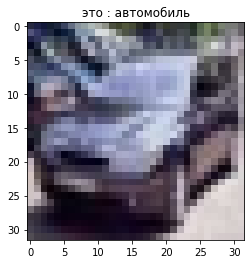

In [4]:
N = 290

plt.imshow(x_test[N][:,:,:])
plt.title('это : ' + classes[np.argmax(y_test[N,:])])
plt.show()

In [67]:
print(f'доступные GPU : {tf.config.experimental.list_physical_devices("GPU")}')

доступные GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [6]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():


    model_first = Sequential()

    model_first.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model_first.add(Activation('relu'))
    model_first.add(MaxPooling2D(pool_size=(2, 2)))
    model_first.add(BatchNormalization())
    model_first.add(Dropout( 0.20))

    model_first.add(Conv2D(128, (3, 3), padding='same'))
    model_first.add(Activation('relu'))
    model_first.add(MaxPooling2D(pool_size=(2, 2)))
    model_first.add(BatchNormalization())
    model_first.add(Dropout( 0.25))

    model_first.add(Conv2D(256, (3, 3), padding='same'))
    model_first.add(Activation('relu'))
    model_first.add(MaxPooling2D(pool_size=(2, 2)))
    model_first.add(BatchNormalization())
    model_first.add(Dropout( 0.20))

    model_first.add(Conv2D(512, (3, 3), padding='same'))
    model_first.add(Activation('relu'))
    model_first.add(MaxPooling2D(pool_size=(2, 2)))
    model_first.add(BatchNormalization())
    model_first.add(Dropout( 0.20))
    
    model_first.add(Conv2D(1024, (3, 3), padding='same'))
    model_first.add(Activation('relu'))
    model_first.add(MaxPooling2D(pool_size=(2, 2)))
    model_first.add(BatchNormalization())
    model_first.add(Dropout( 0.20))


    model_first.add(Flatten())
    model_first.add(Dense(128))
    model_first.add(BatchNormalization())
    model_first.add(Activation('relu'))
    model_first.add(Dropout(0.3))

    model_first.add(Dense(256))
    model_first.add(BatchNormalization())
    model_first.add(Activation('relu'))
    model_first.add(Dropout(0.3))

    model_first.add(Dense(512))
    model_first.add(BatchNormalization())
    model_first.add(Activation('relu'))
    model_first.add(Dropout(0.3))

    model_first.add(Dense(num_classes))
    model_first.add(Activation('softmax'))

    model_first.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if not data_augmentation:
        print('Не используется data augmentation')
        history_model_first = model_first.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                                              validation_data=(x_test, y_test), shuffle=True)
    else:
        datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)


        history_model_first = model_first.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                                        epochs=epochs, validation_data=(x_test, y_test),workers=4)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_first.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model_first.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

/home/oshkuk/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 34 all-reduces with algorithm = nccl, num_packs = 1
98/98 [==============================] - 24s 129ms/step - loss: 2.1042 - accuracy: 0.2647 - val_loss: 4.0912 - val_accuracy: 0.1000
Epoch 2/30
98/98 [==============================] - 11s 109ms/step - loss: 1.4321 - accuracy: 0.4773 - val_loss: 7.8790 - val_accuracy: 0.1000
Epoch 3/30
98/98 [==============================] - 11s 112ms/step - loss: 1.1791 - accuracy: 0.5760 - val_loss: 5.5282 - val_accuracy: 0.1306
Epoch 4/30
98/98 [==============================] - 12s 123ms/step - loss: 1.0470 - accuracy: 0.6315 - val_loss: 4.8621 - val_accuracy: 0.1084
Epoch 5/30
98/98 [==============================] - 12s 118ms/step - loss: 0.9354 - accuracy: 0.6701 - val_loss: 4.2903 - val_accuracy: 0.2211
Epoch 6/30
98/98 [==============================] - 11s 107ms/step - loss: 0.8423 - accuracy: 0.7093 - val_loss: 

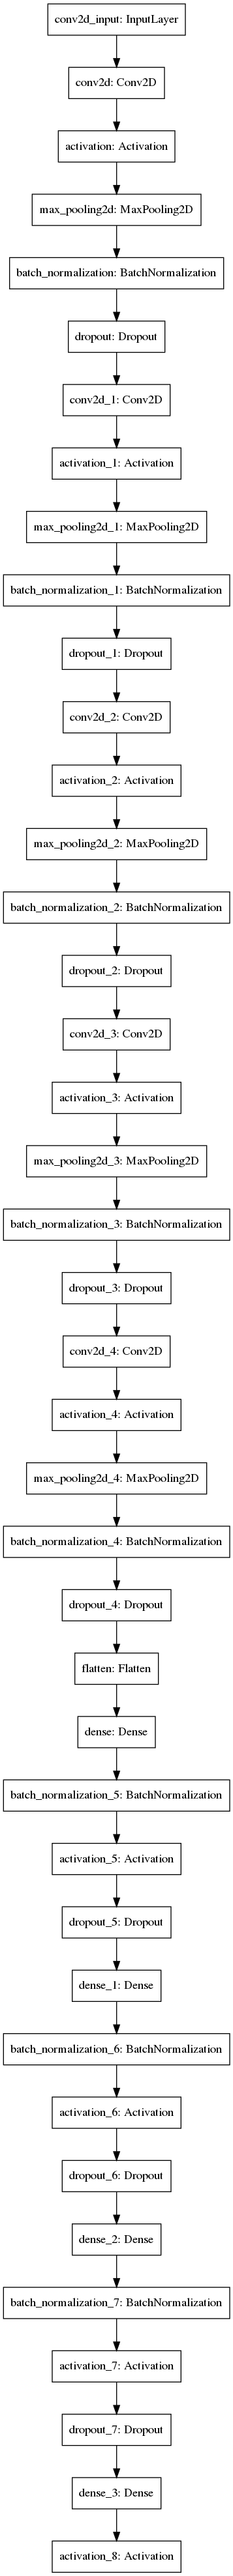

In [7]:
plot_model(model_first,'model_stek.png')

In [8]:
model_first.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0

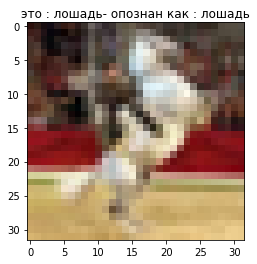

In [9]:
N = 119
y_p=model_first.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

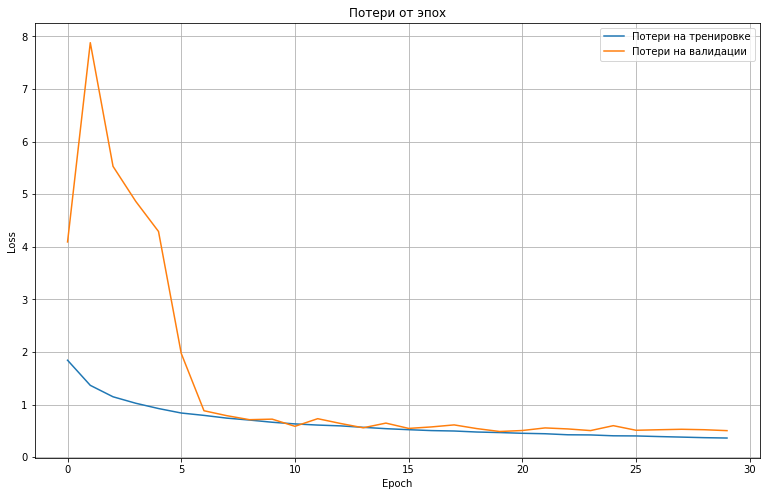

In [10]:
plt.figure(figsize=[13, 8])
plt.plot(history_model_first.history['loss'], label='Потери на тренировке')
plt.plot(history_model_first.history['val_loss'], label='Потери на валидации')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid('On')
plt.title('Потери от эпох')
plt.show()

In [11]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    model_two = Sequential()

    model_two.add(Conv2D(6, (5, 5), padding='valid', input_shape=(32, 32, 3)))
    model_two.add(Activation('relu'))
    model_two.add(AveragePooling2D(pool_size=(2, 2)))
    model_two.add(BatchNormalization())
    model_two.add(Dropout( 0.25))

    model_two.add(Conv2D(16, (5, 5), padding='same'))
    model_two.add(Activation('relu'))
    model_two.add(AveragePooling2D(pool_size=(2, 2)))
    model_two.add(BatchNormalization())
    model_two.add(Dropout( 0.25))

    model_two.add(Conv2D(1920, (5, 5), padding='same'))
    model_two.add(Activation('relu'))
    model_two.add(AveragePooling2D(pool_size=(2, 2)))
    model_two.add(BatchNormalization())
    model_two.add(Dropout( 0.25))
    
    model_two.add(Conv2D(1920, (3, 3), padding='same'))
    model_two.add(Activation('relu'))
    model_two.add(AveragePooling2D(pool_size=(2, 2)))
    model_two.add(BatchNormalization())
    model_two.add(Dropout( 0.25))

    model_two.add(Flatten())
    model_two.add(Dense(120))
    model_two.add(BatchNormalization())
    model_two.add(Activation('relu'))
    model_two.add(Dropout(0.3))

    model_two.add(Dense(84))
    model_two.add(BatchNormalization())
    model_two.add(Activation('relu'))
    model_two.add(Dropout(0.3))

    model_two.add(Dense(num_classes))
    model_two.add(Activation('softmax'))

    model_two.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
    

    if not data_augmentation:
        print('Не используется data augmentation')
        history_model_two = model_two.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                                          validation_data=(x_test, y_test), shuffle=True)
    else:
        datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

        history_model_two = model_two.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                                    epochs=epochs, validation_data=(x_test, y_test), workers=4)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_two.save(model_path)
print('сохранить обученную модель как %s ' % model_path + '_2')

scores = model_two.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/home/oshkuk/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
98/98 [==============================] - 26s 203ms/step - loss: 2.0686 - accuracy: 0.2662 - val_loss: 2.2445 - val_accuracy: 0.1459
Epoch 2/30
98/98 [==============================] - 16s 163ms/step - loss: 1.5875 - accuracy: 0.4294 - val_loss: 2.3847 - val_accuracy: 0.1256
Epoch 3/30
98/98 [==============================] - 16s 163ms/step - loss: 1.4556 - accuracy: 0.4772 - val_loss: 1.9814 - val_accuracy: 0.2624
Epoch 4/30
98/98 [==============================] - 16s 163ms/step - loss: 1.3733 - accuracy: 0.5143 - val_loss: 2.4328 - val_accuracy: 0.2428
Epoch 5/30
98/98 [==============================] - 16s 163ms/step - loss: 1.2933 - accuracy: 0.5451 - val_loss: 1.8478 - val_accuracy: 0.4219
Epoch 6/30
98/98 [==============================] - 16s 164ms/step - loss: 1.2190 - accuracy: 0.5715 - val_loss: 

In [13]:
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 6)         24        
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
activation_10 (Activation)   (None, 14, 14, 16)       

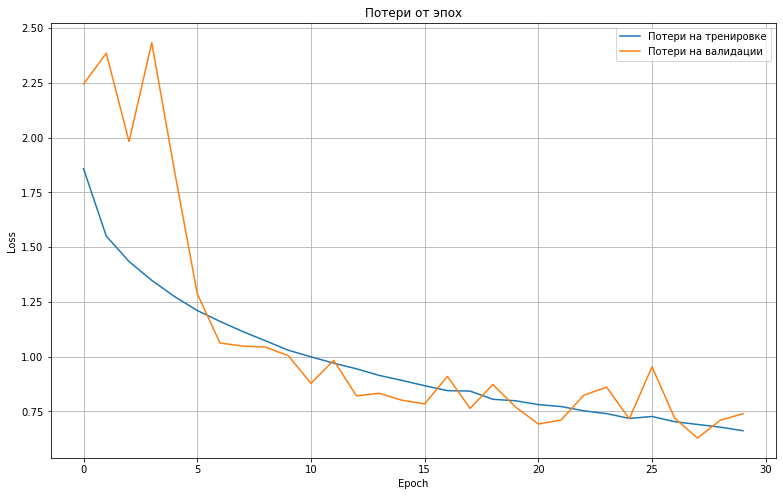

In [14]:
plt.figure(figsize=[13, 8])
plt.plot(history_model_two.history['loss'], label='Потери на тренировке')
plt.plot(history_model_two.history['val_loss'], label='Потери на валидации')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid('On')
plt.title('Потери от эпох')
plt.show()

In [89]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    first_input = Input(shape=(32,32,3 ))
    x = Conv2D(64, (3, 3), padding='same')(first_input)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.20)(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.20)(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.20)(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.20)(x)
    
    x = Conv2D(1024, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    out_first = Dropout(0.20)(x)
    
    two_input = Input(shape=(32,32,3 ))
    y = Conv2D(6, (5, 5), padding='valid')(two_input)
    y = Activation('relu')(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = BatchNormalization()(y)
    y = Dropout(0.20)(y)
    
    y = Conv2D(16, (5, 5), padding='same')(y)
    y = Activation('relu')(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = BatchNormalization()(y)
    y = Dropout(0.20)(y)
    
    y = Conv2D(1920, (5, 5), padding='valid')(y)
    y = Activation('relu')(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = BatchNormalization()(y)
    out_two = Dropout(0.20)(y)
    
    merge = Concatenate()([out_first, out_two]) 
    
    z = Flatten()(merge)
    z = Dense(128)(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Dropout(0.20)(z)
    
    z = Dense(256)(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Dropout(0.20)(z)
    
    z = Dense(512)(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Dropout(0.20)(z)
    
    z = Dense(num_classes)(z)
    z = Activation('softmax')(z)
    
    model_ = Model(inputs=[first_input, two_input], outputs=z)
    
    model_.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    if not data_augmentation:
        print('Не используется data augmentation')
        history_model_merge = model_.fit([x_train, x_train], y_train, batch_size=batch_size, epochs=epochs, validation_data=([x_test, x_test], y_test), shuffle=True)
    else:
        datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

        history_model_merge = model_.fit_generator(datagen.flow([x_train, x_train], y_train, batch_size=batch_size),
                                                   epochs=epochs, validation_data=([x_test, x_test], y_test), workers=4)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_.save(model_path)
print('сохранить обученную модель как %s ' % model_path + '_merge')

scores = model_.evaluate([x_test, x_test], y_test, verbose=1) 
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/30
98/98 [==============================] - 19s 137ms/step - loss: 1.8964 - accuracy: 0.3280 - val_loss: 4.3218 - val_accuracy: 0.1000
Epoch 2/30
98/98 [==============================] - 13s 127ms/step - loss: 1.2693 - accuracy: 0.5405 - val_loss: 10.5873 - val_accuracy: 0.1000
Epoch 3/30
98/98 [==============================] - 13s 124ms/step - loss: 1.0831 - accuracy: 0.6164 - val_loss: 5.9283 - val_accuracy: 0.1683
Epoch 4/30
98/98 [==============================] - 12s 118ms/step - loss: 0.9366 - accuracy: 0.6693 - val_loss: 5.4309 - val_accuracy: 0.1563
Epoch 5/30
98/98 [==============================] - 13s 122ms/step - loss: 0.8371 - accuracy: 0.7070 - val_loss: 3.8294 - val_accuracy: 0.1941
Epoch 6/30
98/98 [==============================] - 12s 115ms/step - loss: 0.7534 - accuracy: 0.7368 - val_loss: 2.6479 - val_accuracy:

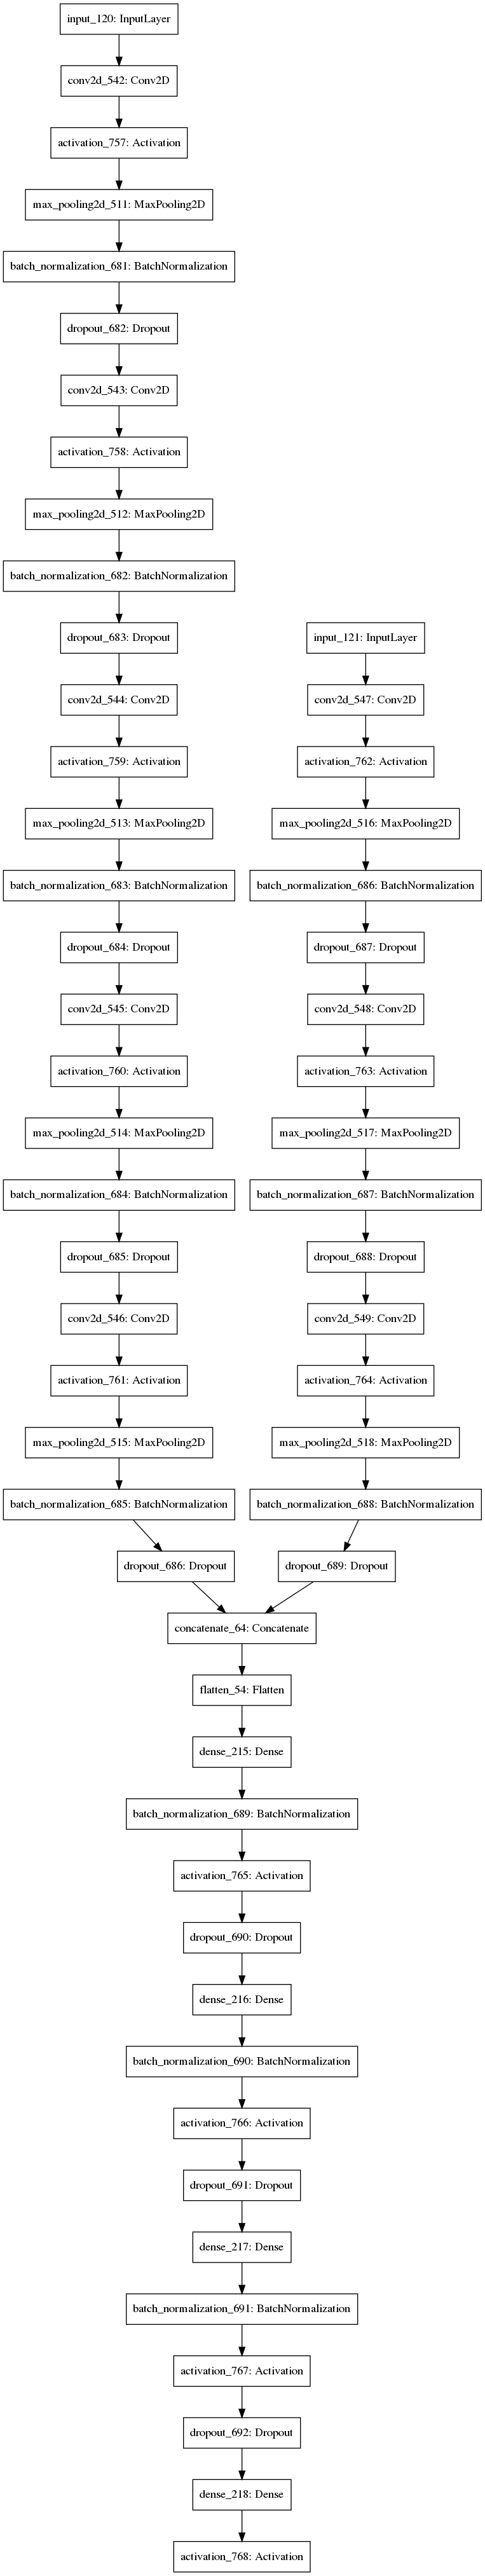

In [90]:
plot_model(model_,'model_stek.png')

In [91]:
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 6)         24        
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
activation_10 (Activation)   (None, 14, 14, 16)       

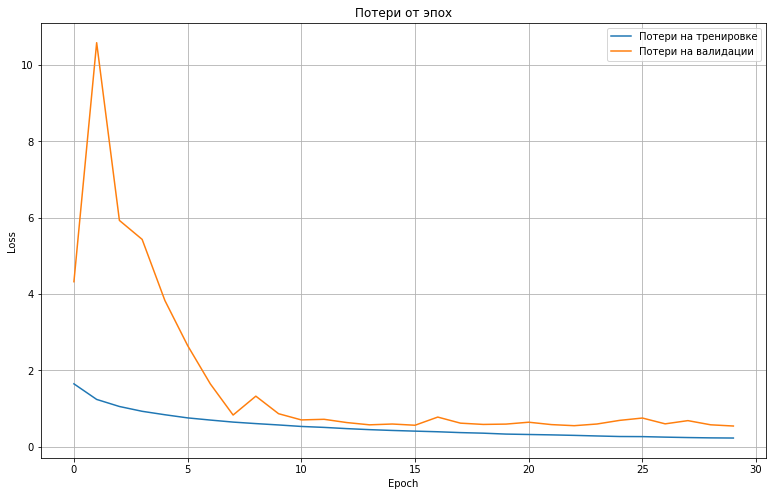

In [92]:
plt.figure(figsize=[13, 8])
plt.plot(history_model_merge.history['loss'], label='Потери на тренировке')
plt.plot(history_model_merge.history['val_loss'], label='Потери на валидации')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid('On')
plt.title('Потери от эпох')
plt.show()

In [95]:
y_pred = model_.predict([x_test,x_test])
y_pred_class = np.argmax(y_pred, axis=1)

y_pred_class

array([3, 8, 8, ..., 5, 1, 7])

In [100]:
from sklearn.metrics import confusion_matrix

In [101]:
matrix_errors = confusion_matrix(y_pred_class, for_matrix)
matrix_errors

array([[917,   5,  59,  24,  17,  12,   9,   9,  44,  19],
       [ 20, 964,   3,  12,   2,   7,   4,   2,  29,  70],
       [  7,   1, 777,  44,  77,  28,  19,  12,   4,   4],
       [  4,   2,  35, 694,  39, 123,  33,  32,   6,   5],
       [ 10,   0,  38,  42, 772,  27,  11,  34,   3,   2],
       [  0,   1,  34, 104,  22, 768,  12,  33,   2,   0],
       [  2,   1,  39,  53,  45,  15, 902,  10,   4,   3],
       [  4,   0,   9,  14,  23,  17,   4, 862,   0,   4],
       [ 26,   3,   3,   5,   3,   1,   3,   2, 895,   8],
       [ 10,  23,   3,   8,   0,   2,   3,   4,  13, 885]])

In [102]:
dict_precision_recall = {}

for i in range(10):
    in_dict = {}
    precision_ = round(matrix_errors[i, i] / np.sum(matrix_errors, axis=1)[i], 4)
    recal_ = round(matrix_errors[i, i] / np.sum(matrix_errors, axis=0)[i], 4)
    in_dict['precision'] = precision_
    in_dict['recal'] = recal_
    in_dict['f_measure'] = round((2 * recal_ * precision_) / (recal_ + precision_), 4)
    dict_precision_recall[str(i)] = in_dict

print(dict_precision_recall)

{'0': {'precision': 0.8224, 'recal': 0.917, 'f_measure': 0.8671}, '1': {'precision': 0.8661, 'recal': 0.964, 'f_measure': 0.9124}, '2': {'precision': 0.7986, 'recal': 0.777, 'f_measure': 0.7877}, '3': {'precision': 0.7133, 'recal': 0.694, 'f_measure': 0.7035}, '4': {'precision': 0.8222, 'recal': 0.772, 'f_measure': 0.7963}, '5': {'precision': 0.7869, 'recal': 0.768, 'f_measure': 0.7773}, '6': {'precision': 0.8399, 'recal': 0.902, 'f_measure': 0.8698}, '7': {'precision': 0.92, 'recal': 0.862, 'f_measure': 0.8901}, '8': {'precision': 0.9431, 'recal': 0.895, 'f_measure': 0.9184}, '9': {'precision': 0.9306, 'recal': 0.885, 'f_measure': 0.9072}}


Экспермент показал, что количество нитей сети не позволяет значительно увеличить качество сети, а количество ядер свертки, а также увеличение количества слоёв сети позволяет увелисть качество сети.